In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from PIL import Image

In [ ]:
# 준비된 이미지 데이터가 없을 때 사용
# !git clone https://github.com/alpha-13/Face-Recognition.git

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
!mkdir /content/images1
!unzip /content/images1 -d /content/images1

In [ ]:
class Config():
    training_dir = "/content/images1/images/Training"
    testing_dir = "/content/images1/images/Testing"
    train_batch_size = 8
    train_number_epochs = 3
    path = "/content/model/siamese_cnn_model.pt"

In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


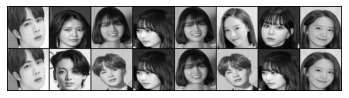

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
'''
 torch.cat()은 주어진 차원을 기준으로 주어진 텐서들을 붙임(concatenate)
 따라서, (3, 4)의 크기(shape)를 갖는 2개의 텐서 A와 B를 붙이는 경우,
 torch.cat([A, B], dim=0)의 결과는 (6, 4)의 크기(shape)를 갖음
'''
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch number 0
 Current loss 1.9818378686904907

Epoch number 1
 Current loss 0.01957426592707634

Epoch number 2
 Current loss 0.14021256566047668



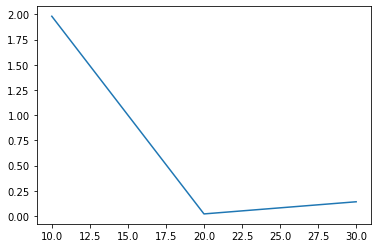

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label = data
        img0, img1, label = img0, img1 , label
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [ ]:
!mkdir /content/model
#모델 저장
torch.save(net, Config.path)

In [ ]:
class GetTwoData(Dataset):
    
    def __init__(self, find_img_tuple, comapare_img_tuple, imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        self.find_img_tuple = find_img_tuple
        self.comapare_img_tuple = comapare_img_tuple
        
    def __getitem__(self,index):
        img0_tuple = find_img_tuple
        img1_tuple = compare_img_tuple

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
result_dict = dict()
model=torch.load(Config.path)

find_src = "/content/images1/Training/s15/다운로드 (32).jpg"

# 테스트 이미지 파일에서 이미지 가져오기
find_train = dset.ImageFolder(root=Config.training_dir)
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

for value in find_train.imgs:
    if (value[0] == find_src):
        find_img_tuple = value
        break

for i in range(1,len(folder_dataset_test)+1):
    compare_src = "/content/images1/Testing/s" + str((i)) + "/" + str((i)) + ".jpg"
    compare_test = dset.ImageFolder(root=Config.testing_dir)
    for value in compare_test.imgs:
        if (value[0] == compare_src):
            compare_img_tuple = value
            break

    siamese_dataset = GetTwoData(find_img_tuple, compare_img_tuple, imageFolderDataset=folder_dataset_test,
                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                           transforms.ToTensor()
                                                           ])
                             ,should_invert=False)

    test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
    dataiter = iter(test_dataloader)
    x0,_,_ = next(dataiter)
    
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    result_dict[compare_src] = euclidean_distance.item()

#결과 값
print(type(result_dict))
print(result_dict)

#정렬
sorted_result = sorted(result_dict.items(), key = lambda item: item[1])

#정렬을 하면 list로 바뀌므로 다시 dictionary로 변환
dict_ = dict(sorted_result)

#dictionary를 json으로 변환
import json
json_result = json.dumps(dict_)
print(type(json_result))
print(json_result)

NameError: ignored